In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
import sys
import matplotlib.pyplot as plt

TEST_PCT      = 0.20
VAL_PCT       = 0.10
SUMMARIES_DIR = '/home/tom/tf_logs' # where to store Tensorboard data
FILENM        = "rbf_data.csv"
CLUSTER_METHOD = 'random'        # "km" "random"
NUM_NODES      = 8
SIGMA          = 2.

In [2]:
## Load the data
if sys.platform[:3] =='win': data_loc = 'D:/Data/Loyalty Vision/'
else: data_loc = "/home/tom/data/"
df = pd.read_csv(data_loc+FILENM, delimiter=',')
data = np.asmatrix(df)

In [3]:
# Split into train and test
train, test = train_test_split(data,  test_size=TEST_PCT)
train, val  = train_test_split(train, test_size=VAL_PCT)

train_x = train[:,0].reshape(-1,1)
train_y = train[:,1].reshape(-1,1)
val_x   = val[:,0].reshape(-1,1)
val_y   = val[:,1].reshape(-1,1)
test_x  = test[:,0].reshape(-1,1)
test_y  = np.array(test[:,1])

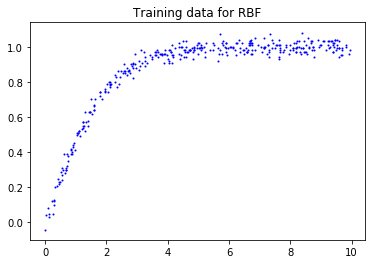

In [4]:
# Plot the training data
a = plt.scatter(train_x, train_y, s=1, color='blue')
plt.title('Training data for RBF')
plt.show()

In [5]:
# Each node has a Center, randomly assigned. Distances are computed to each Center
if CLUSTER_METHOD == 'km':
    print('Clustering via k-means')
    centers = KMeans(n_clusters=NUM_NODES).fit(train_x).cluster_centers_
else:
    print('Clustering via random sample')
    mask = np.random.randint(0, len(train_x), size=[NUM_NODES])
    centers = np.array(train_x[mask])

Clustering via random sample


In [6]:
tf.reset_default_graph()

# Set up the design matrix
c   = tf.placeholder("float", shape=[train_x.shape[1]])
x   = tf.placeholder("float", shape=[None,train_x.shape[1]])
y_  = tf.placeholder("float", shape=[None,train_y.shape[1]])
DM  = tf.placeholder("float", shape=[None,NUM_NODES])
#
# "rbf" is the radial basis function. Each "x" is processed by each node, so for 50
# samples and a 3-node network, you'd produce a 50x3 array
# Each node will have a different "c" Center but otherwise the same
rbf = tf.exp(-tf.div(tf.pow(tf.sub(x, c),2), tf.pow(SIGMA,2)))

# Loop through the nodes. Use a different "c" each time and accumulate results in rbf_array
# The array has an initial "zeros" just to get the shape right and allow "insert"
rbf_array = np.zeros(shape=[len(train_x),1])

test = tf.sub(x,c)

for i in range(NUM_NODES):
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        tmp = sess.run(rbf, feed_dict={x: train_x, c: centers[i]})
    rbf_array = np.insert(rbf_array, i+1, tmp.flatten(), axis=1)

# Now you can delete that placeholder column of zeros
rbf_array = np.delete(rbf_array,0, axis=1)

In [7]:
# Generate the weights with a series of matrix manipulations
step1   = tf.matmul(DM, DM, transpose_a=True)
step2   = tf.matrix_inverse(step1)
step3   = tf.matmul(step2,DM, transpose_b=True)
weights = tf.matmul(step3, y_)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    opt_weights = sess.run(weights, feed_dict={DM: rbf_array, y_: train_y})

In [8]:
# Now that the weights are optimized, run the test batch through and see what you get
# First, generate a new Design Matrix, which is the test_x values run through the rbf
rbf_array = np.zeros(shape=[len(test_x),1])

for i in range(NUM_NODES):
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        tom = sess.run(rbf, feed_dict={x: test_x, c: centers[i]})
    rbf_array = np.insert(rbf_array, i+1, tom.flatten(), axis=1)
rbf_array = np.delete(rbf_array,0, axis=1)

# Now multiply the DM by the weights for the fitted values
final = tf.matmul(DM, weights)
with tf.Session() as sess:
    fitted_y = sess.run(final, feed_dict={DM: rbf_array, weights: opt_weights})

mse = np.mean((fitted_y-test_y)**2)
print('RMSE: {:.3f}'.format(mse))

RMSE: 0.003


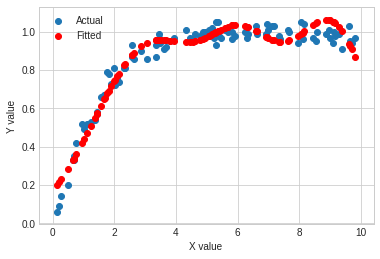

Playing WAVE '/usr/share/sounds/bicycle_bell.wav' : Signed 16 bit Little Endian, Rate 11127 Hz, Mono


In [9]:
# Plot the results
with plt.style.context('seaborn-whitegrid'):
    plt.scatter(test_x,test_y, label='Actual')
    plt.scatter(test_x, fitted_y, label='Fitted',c='red')
    plt.xlabel("X value")
    plt.ylabel("Y value")
    plt.legend(loc='upper left')
    plt.show()
!aplay /usr/share/sounds/bicycle_bell.wav